# ResNet-34 PyTorch Starter Kit

- Updates:
  - added result for training with 400 epochs


- References (ResNet):
  - https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
  - https://arxiv.org/pdf/1512.03385.pdf
  
  
- Acknowledgements:
  - Original kernels: https://www.kaggle.com/hanjoonchoe/grapheme-resnet-18-n-l-inference-lb-0-8566 and https://www.kaggle.com/hanjoonchoe/grapheme-resnet-18-naive-learning-3
  
  
- Kindly upvote the kernel if you found it helpful, including the original author's!

# Part 1

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

In [11]:
train = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
data0 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/test_data_0.feather')
data1 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/test_data_1.feather')
data2 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/test_data_2.feather')
data3 = pd.read_feather('/kaggle/usr/lib/resize-and-load-with-feather-format-much-faster/test_data_3.feather')

In [12]:
ls /kaggle/usr/lib/resize_and_load_with_feather_format_much_faster/

ls: cannot access '/kaggle/usr/lib/resize_and_load_with_feather_format_much_faster/': No such file or directory


In [15]:
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)

In [16]:
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train'):
        self.df = df
        self.label = label
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        image = self.df.iloc[idx][1:].values.reshape(64,64).astype(np.float)
        return image,label1,label2,label3

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

## ResNet-18 Model

In [18]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512,11)
        # grapheme_root
        self.fc2 = nn.Linear(512,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

## ResNet34 Model

In [19]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512,11)
        # grapheme_root
        self.fc2 = nn.Linear(512,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

## Remarks

- See previous version for torch summary as submission must not have internet enabled

In [24]:
#!pip install torchsummary
#from torchsummary import summary

^C


ModuleNotFoundError: No module named 'torchsummary'

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#model_resnet34 = ResNet34().to(device)
#summary(model_resnet34, (1, 64, 64))

## Training Model

- We use ResNet34 and train for 50 epochs

In [26]:
model = ResNet34().to(device)
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=0.05)
criterion = nn.CrossEntropyLoss()
batch_size=32

In [27]:
epochs = 50 # original 50
model.train()
losses = []
accs = []
for epoch in range(epochs):
    reduced_index =train.groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(lambda x: x.sample(5)).image_id.values
    reduced_train = train.loc[train.image_id.isin(reduced_index)]
    reduced_data = data_full.loc[data_full.image_id.isin(reduced_index)]
    train_image = GraphemeDataset(reduced_data,reduced_train)
    train_loader = torch.utils.data.DataLoader(train_image,batch_size=batch_size,shuffle=True)
    
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(train_loader),total=len(train_loader)):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        
        optimizer.zero_grad()
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = criterion(outputs1,labels1)
        loss2 = criterion(outputs2,labels2)
        loss3 = criterion(outputs3,labels3)
        running_loss += loss1+loss2+loss3
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
        (loss1+loss2+loss3).backward()
        optimizer.step()
    #scheduler.step()
    losses.append(running_loss/len(train_loader))
    accs.append(running_acc/(len(train_loader)*3))
    print('acc : {:.2f}%'.format(running_acc/(len(train_loader)*3)))
    print('loss : {:.4f}'.format(running_loss/len(train_loader)))
torch.save(model.state_dict(), 'resnet34_50epochs_saved_weights.pth')

ValueError: num_samples should be a positive integer value, but got num_samples=0

Text(0.5, 1.0, 'acc')

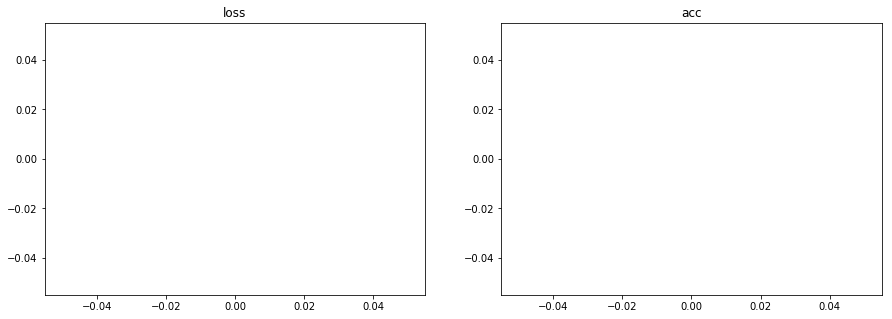

In [28]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('loss')
ax[1].plot(accs)
ax[1].set_title('acc')

# Part 2

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

/kaggle/input/grapheme-resnet-18-naive-learning-2/__results__.html
/kaggle/input/grapheme-resnet-18-naive-learning-2/saved_weights.pth
/kaggle/input/grapheme-resnet-18-naive-learning-2/__resultx__.html
/kaggle/input/grapheme-resnet-18-naive-learning-2/__notebook__.ipynb
/kaggle/input/grapheme-resnet-18-naive-learning-2/__output__.json
/kaggle/input/grapheme-resnet-18-naive-learning-2/custom.css
/kaggle/input/grapheme-resnet-18-naive-learning-2/__results___files/__results___10_1.png
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_multi_diacritics.csv
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/t

In [31]:
test = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')

In [32]:
class GraphemeDataset(Dataset):
    def __init__(self,df,_type='train'):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image = self.df.iloc[idx][1:].values.reshape(64,64).astype(float)
        return image

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet34().to(device)
model.load_state_dict(torch.load('/kaggle/input/trained400/resnet34_400epochs_saved_weights.pth'))

<All keys matched successfully>

In [34]:
def Resize(df,size=64):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

In [35]:
model.eval()
test_data = ['test_image_data_0.parquet','test_image_data_1.parquet','test_image_data_2.parquet','test_image_data_3.parquet']
predictions = []
batch_size=1
for fname in test_data:
    data = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/{fname}')
    data = Resize(data)
    test_image = GraphemeDataset(data)
    test_loader = torch.utils.data.DataLoader(test_image,batch_size=1,shuffle=False)
    with torch.no_grad():
        for idx, (inputs) in tqdm(enumerate(test_loader),total=len(test_loader)):
            inputs.to(device)
            
            outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float().cuda())
            predictions.append(outputs3.argmax(1).cpu().detach().numpy())
            predictions.append(outputs2.argmax(1).cpu().detach().numpy())
            predictions.append(outputs1.argmax(1).cpu().detach().numpy())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


# Save Results

In [36]:
submission = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [37]:
submission.target = np.hstack(predictions)
submission.head(10)

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0


In [38]:
submission.to_csv('submission.csv',index=False)